In [ ]:
# --- Colab bootstrap: clone/update and install `boilers` ---
import os
import subprocess
import sys

IN_COLAB = "google.colab" in sys.modules
REPO = "https://github.com/acb-code/boilers.git"
WORKDIR = "/content/boilers"
BRANCH = "main"

def sh(cmd):
    print(">>", " ".join(cmd))
    subprocess.run(cmd, check=True)

if IN_COLAB:
    if not os.path.exists(WORKDIR):
        sh(["git", "clone", REPO, WORKDIR])
    os.chdir(WORKDIR)
    sh(["git", "fetch", "origin"])
    sh(["git", "checkout", BRANCH])
    sh(["git", "reset", "--hard", f"origin/{BRANCH}"])

    # Always ensure a modern IPython for Py3.12 before loading extensions

    import IPython
    ip = IPython.get_ipython()
    ip.run_line_magic("pip", "install -q -U ipython pip setuptools wheel")
    # Install your package (dev extras) in editable mode
    ip.run_line_magic("pip", "install -q -e '.[dev]'")

    # (Optional) If IPython was upgraded in this call, a restart is safest.
    # You can uncomment the following two lines if you want an automatic restart:
    # print("Restarting runtime to finalize IPython upgrade…")
    # _os.kill(_os.getpid(), 9)

# Safety net: make sure `src/` is importable
src_path = os.path.join(WORKDIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)


In [10]:
import inspect
import os
import sys

import torch  # imports first (fixes E402)

import boilers

print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("CWD:", os.getcwd())
print("sys.path[0]:", sys.path[0])

print("boilers imported from:", inspect.getfile(boilers))


Torch: 2.8.0+cu128 | CUDA: False
CWD: /home/alex/code/boilers/notebooks/2025-10-05-intro
sys.path[0]: /content/boilers/src
boilers imported from: /home/alex/code/boilers/src/boilers/__init__.py


In [11]:
%load_ext autoreload
%autoreload 2

import random

import numpy as np
import torch


def set_seed(s=1337):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

set_seed()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [12]:
import torch.nn as nn

from boilers.data.datasets import moons
from boilers.models.logistic import LogisticClassifier
from boilers.models.mlp import MLP
from boilers.training.loop import TrainCfg, fit

train_dl, val_dl, meta = moons(batch_size=128)

# Try logistic regression
logreg = LogisticClassifier(meta["input_dim"], meta["num_classes"])
cfg_lr = TrainCfg(epochs=5, lr=1e-2, optimizer="sgd")
hist_lr = fit(logreg, train_dl, val_dl, cfg_lr, loss_fn=nn.CrossEntropyLoss())

# Try a small MLP
mlp = MLP(input_dim=meta["input_dim"], hidden_sizes=(64,64), num_classes=meta["num_classes"])
cfg_mlp = TrainCfg(epochs=10, lr=1e-3, optimizer="adam")
hist_mlp = fit(mlp, train_dl, val_dl, cfg_mlp, loss_fn=nn.CrossEntropyLoss())


epoch 01 | train 0.4508 | val 0.3779 | acc 0.818
epoch 02 | train 0.3377 | val 0.3260 | acc 0.850
epoch 03 | train 0.3084 | val 0.3098 | acc 0.859
epoch 04 | train 0.2976 | val 0.3029 | acc 0.859
epoch 05 | train 0.2926 | val 0.2993 | acc 0.866
epoch 01 | train 0.5205 | val 0.3569 | acc 0.865
epoch 02 | train 0.3000 | val 0.2745 | acc 0.891
epoch 03 | train 0.2514 | val 0.2403 | acc 0.916
epoch 04 | train 0.2171 | val 0.2065 | acc 0.931
epoch 05 | train 0.1799 | val 0.1725 | acc 0.940
epoch 06 | train 0.1466 | val 0.1447 | acc 0.955
epoch 07 | train 0.1185 | val 0.1258 | acc 0.965
epoch 08 | train 0.1015 | val 0.1099 | acc 0.974
epoch 09 | train 0.0904 | val 0.1048 | acc 0.973
epoch 10 | train 0.0836 | val 0.1039 | acc 0.974


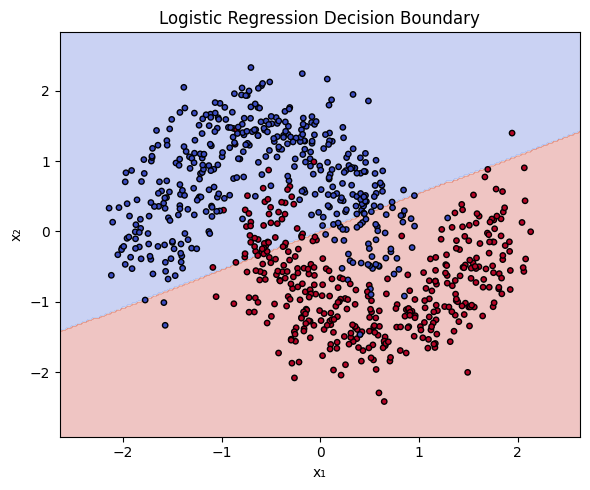

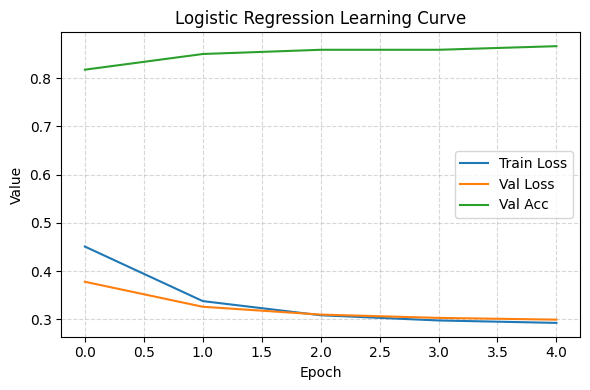

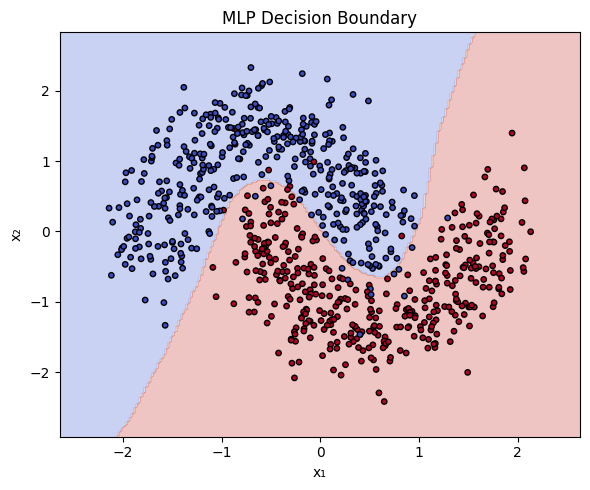

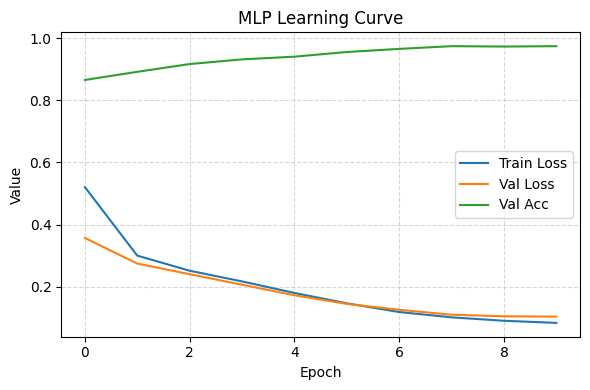

In [14]:
from boilers.nb.nbtools import plot_decision_boundary, plot_learning_curves

# --- Logistic regression visualization ---
plot_decision_boundary(logreg, val_dl, title="Logistic Regression Decision Boundary")
plot_learning_curves(hist_lr, title="Logistic Regression Learning Curve",
                     metrics=("train_loss", "val_loss", "val_acc"))

# --- MLP visualization ---
plot_decision_boundary(mlp, val_dl, title="MLP Decision Boundary")
plot_learning_curves(hist_mlp, title="MLP Learning Curve",
                     metrics=("train_loss", "val_loss", "val_acc"))
